In [1]:
# Import all the required Libraries

import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Ellipse
import seaborn as sns
import pandas as pd
import networkx as nx
import math
import csv
import matplotlib.pylab as pyl
import itertools

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read all the event files of all the leagues
events=[]
leagues = ['Italy','England','Germany','France','Spain','European_Championship','World_Cup']
for league in leagues:
    events.append(pd.read_json('dataset\events\events_%s.json' %league))

In [3]:
# Read all the matches in all the leagues
matches=[]
leagues = ['Italy','England','Germany','France','Spain','European_Championship','World_Cup']
for match in leagues:
    matches.append(pd.read_json('dataset\matches\matches_%s.json' %match))

In [4]:
# Read required input files

player_df = pd.read_json("dataset\players.json")
team_data_df = pd.read_json("dataset/teams.json") 


In [5]:
# Data Preprocessing

# Conversion of special character into normal character in players name

def jsonparse(x):
    s = '"'+x+'"'
    s = s.replace('	', '')
    return json.loads(s.replace('	', ''))

player_df['shortName'] = player_df['shortName'].map(lambda x: jsonparse(x))


# Addition of a player name based on player id in the event dataframe

a=player_df[['wyId','shortName']]    # Selecting the player name from player dataframe

for event in events:    
    b=event[['playerId']]             # Selecting the playerId from the event dataframe
    c=b.merge(a,how='left', left_on='playerId', right_on='wyId')  # Merging both the dataframe
    event["player"] = c.shortName           # Addition of the player name in the event dataframe



In [6]:
def passing_network(event_df, match_df, match_Id = 2499954):
    
 
    team_temp_list = []   # Temporary team metric list
    
   
    match_description = match_df.label.values[0] 
    

    
   
    # Filtering the passing events
    pass_events = event_df[event_df.eventName == 'Pass']

    pass_events = pass_events.dropna(how='any',axis=0)

    
    # Altering the time of the event in the second half by adding the maximum time of the first half
    first_half_max_duration = np.max(pass_events[pass_events['matchPeriod'] == '1H']['eventSec'])
    pass_events.loc[pass_events.matchPeriod == "2H", "eventSec"] = pass_events.eventSec + first_half_max_duration  
    
   
      
        
    # Segregation of teams  and team passes in the match
    
    team_id=pass_events.teamId.unique()
    
    # Team names
    team1_name = team_data_df.name[team_data_df['wyId']==team_id[0]].values[0]
    team2_name = team_data_df.name[team_data_df['wyId']==team_id[1]].values[0]
    
    Teams_Played = team1_name + '-' + team2_name
    
    # Seperation of the passess 
    team1_pass_events = pass_events[pass_events['teamId'] == team_id[0]]
    team2_pass_events = pass_events[pass_events['teamId'] == team_id[1]]       
       

    # Result of the match
    winner = match_df.winner.values[0]
#     winner = match_df.winner[match_df['wyId'] == match_Id].values[0]
    
    if winner == team_id[0]:
        team_temp_list.append("Team_1")
    else:
        if winner == team_id[1]:
            team_temp_list.append("Team_2")
        else:
            team_temp_list.append("Draw")       
        

    
        

#   split pass between team1 and team2 
    
    team_1 = pd.DataFrame()
    
    team_1['sender'] = team1_pass_events.player
    team_1['receiver'] = team1_pass_events.player.shift(-1).dropna()
    
    team_2 = pd.DataFrame()
    team_2['sender'] = team2_pass_events.player
    team_2['receiver'] = team2_pass_events.player.shift(-1).dropna()
    
 


    #create dataframe of sender and receiver with number of passes for team 1
    
    df_team1 = []
    for i,row in team_1.iterrows():
        if row['sender'] == row['receiver']:
            pass        
        else:
            df_team1.append([row['sender'],row['receiver']])
    df_team1 = pd.DataFrame(df_team1, columns=['sender','receiver']) 
    
    # Dataframe with total number of passess between two player of team 1
    df_team1_count = df_team1.groupby(['sender','receiver']).size().reset_index(name="No_of_Passes")
    
      
         
    # Total number of passess in team 1 
   
    team1_total_passes = df_team1_count.No_of_Passes.sum()     
       
    



    # create dataframe of sender and receiver with number of passes for team 2

    df_team2 = []
    for i,row in team_2.iterrows():
        if row['sender'] == row['receiver']:
            pass        
        else:
            df_team2.append([row['sender'],row['receiver']])
    df_team2 = pd.DataFrame(df_team2, columns=['sender','receiver']) 
    
    # Dataframe with total number of passess between two player of team 2
    df_team2_count = df_team2.groupby(['sender','receiver']).size().reset_index(name="No_of_Passes")
    
    # Total number of passess in team 2 
   
    team2_total_passes = df_team2_count.No_of_Passes.sum()  
   

    

    # Calculation of position of the player for team 1   

    pos1 = {}
    actual_pos1 = {}
    pos1_relative = {}  # Position of the player with respect to football pitch layout
    
        
    for player in list(df_team1['sender'].unique()):
        x, y = [], []
        df_match_player = pass_events[pass_events.player==player]
        for i,row in df_match_player.iterrows():
            x.append(row['positions'][0]['x'])            
            y.append(row['positions'][0]['y'])
            
        # Mean position of the player
        actual_pos1[player] = (int(np.mean(x)), int(np.mean(y)))
        pos1[player] = (int(105 - np.mean(x)), int(69-(np.mean(y))))
        pos1_relative[(player)] = (int(105 - np.mean(x)), int(69-(np.mean(y)/100 * 69)))
        
        
       
    
    # Calculation of the average possession position of the team 1
    pos1_df =  pd.DataFrame(actual_pos1).T.reset_index()
    pos1_df.columns = ['Player','X','Y']
    
    team1_possession_mean_x = pos1_df["X"].mean()
    team1_possession_mean_y = pos1_df["Y"].mean()
    
    
  
        
    # Calculation of position of the player for team 2  

    pos2 = {}
    actual_pos2 = {}
    pos2_relative = {}  # Position of the player with respect to football pitch layout
    
    for player in list(df_team2['sender'].unique()):
        x, y = [], []
        df_match_player = pass_events[pass_events.player==player]
        for i,row in df_match_player.iterrows():
            x.append(row['positions'][0]['x'])
            y.append(row['positions'][0]['y'])
        
        # Mean position of the players during the match
                
        actual_pos2[player] = (int(np.mean(x)), int(np.mean(y)))
        pos2[(player)] = (int(np.mean(x)), int(np.mean(y)))        
        pos2_relative[(player)] = (int(np.mean(x)), int(np.mean(y)/100 * 69))
        
    
   
     # Calculation of the average possession position of the team 2
    pos2_df =  pd.DataFrame(actual_pos2).T.reset_index()
    pos2_df.columns = ['Player','X','Y']
    
    team2_possession_mean_x = pos2_df["X"].mean()
    team2_possession_mean_y = pos2_df["Y"].mean()   
 
    
    
  # Passing Network for the team 1
    
    g = nx.Graph()
    for i,row in df_team1_count.iterrows():
        g.add_edge(row['sender'],row['receiver'],weight=row['No_of_Passes'])
    deg = dict(g.degree)
    team1_degree = 0
    for player_deg in deg.values():
        team1_degree = team1_degree + player_deg
    
    
    team1_centrality = round(nx.global_reaching_centrality(g),2)
    team1_avg_clustering = round(nx.average_clustering(g),2)
    team1_connectivity = round(nx.algebraic_connectivity(g),2)
    team1_density = round(nx.density(g),2)
    team1_diameter = nx.diameter(g)
    team1_asp = round(nx.average_shortest_path_length(g),2)
    
    

       

    
    # Passing Network for the team 2
    
    r = nx.Graph()
    for i,row in df_team2_count.iterrows():
        r.add_edge(row['sender'],row['receiver'],weight=row['No_of_Passes'])
    deg = dict(r.degree)
    team2_degree = 0
    for player_deg in deg.values():
        team2_degree = team2_degree + player_deg
    
    team2_centrality = round(nx.global_reaching_centrality(r),2)
    team2_avg_clustering = round(nx.average_clustering(r),2)
    team2_connectivity =round(nx.algebraic_connectivity(r),2)
    team2_density = round(nx.density(r),2)
    team2_diameter = nx.diameter(r)
    team2_asp = round(nx.average_shortest_path_length(r),2)
    

        

        
        
    # Append all the features in the original list
     
    team_temp_list.append(Teams_Played)                                      
    team_temp_list.append(team1_name)
    team_temp_list.append(team2_name)
    team_temp_list.append(team1_total_passes)
    team_temp_list.append(team2_total_passes)
    team_temp_list.append(round(team1_possession_mean_x,2))
    team_temp_list.append(round(team1_possession_mean_y,2))
    team_temp_list.append(round(team2_possession_mean_x,2))
    team_temp_list.append(round(team2_possession_mean_y,2))
    team_temp_list.append(team1_degree)
    team_temp_list.append(team2_degree)
    team_temp_list.append(team1_centrality)
    team_temp_list.append(team2_centrality)
    team_temp_list.append(team1_avg_clustering)
    team_temp_list.append(team2_avg_clustering)
    team_temp_list.append(team1_connectivity)
    team_temp_list.append(team2_connectivity)
    team_temp_list.append(team1_density)
    team_temp_list.append(team2_density) 
    team_temp_list.append(team1_diameter)
    team_temp_list.append(team2_diameter)
    team_temp_list.append(team1_asp)
    team_temp_list.append(team2_asp)
    
    

    
    teams_metrics_list.append(team_temp_list)
   

    
  
    
    


In [7]:
# Generate the network metrics for each match

teams_metrics_list = []  
for idx, match_df in enumerate(matches):
    events_df = events[idx]
    for match_id in match_df.wyId:
        row = match_df[match_df.wyId == match_id]
        event_df = events_df[events_df.matchId == match_id]
        passing_network(event_df, row, match_id)

In [30]:
data=np.array(teams_metrics_list)

data.shape


(1941, 24)

In [31]:
columns = ['Winner','Teams','Team_1', 'Team_2', 'T1_Passes','T2_Passes','T1_possession_X','T1_possession_Y','T2_possession_X','T2_possession_Y','T1_degree','T2_degree','T1_Centrality','T2_Centrality','T1_Avg_Cluster','T2_Avg_Cluster','T1_Connectivity','T2_Connectivity','T1_Density','T2_Density','T1_Diameter','T2_Diameter','T1_ASP','T2_ASP']
feature_df = pd.DataFrame(data, columns=columns) 

In [32]:
temp = feature_df['Winner']
feature_df.drop(labels=['Winner'], axis=1, inplace = True)
feature_df.insert(23, 'Winner', temp)
feature_df

,Teams,Team_1,Team_2,T1_Passes,T2_Passes,T1_possession_X,T1_possession_Y,T2_possession_X,T2_possession_Y,T1_degree,...,T2_Avg_Cluster,T1_Connectivity,T2_Connectivity,T1_Density,T2_Density,T1_Diameter,T2_Diameter,T1_ASP,T2_ASP,Winner
0,Internazionale-Lazio,Internazionale,Lazio,480,285,48.21,47.43,46.57,42.57,122,...,0.85,1.98,5.87,0.67,0.79,2,2,1.33,1.21,Team_1
1,Sassuolo-Roma,Sassuolo,Roma,326,479,47.07,50.14,46.71,53.43,136,...,0.89,6.09,6.25,0.75,0.81,2,2,1.25,1.19,Team_2
2,Cagliari-Atalanta,Cagliari,Atalanta,220,568,46.85,51.31,46.31,48.62,130,...,0.91,7.19,3.19,0.83,0.82,2,2,1.17,1.18,Team_1
3,Benevento-Chievo,Benevento,Chievo,700,184,51.07,52.29,46.85,52.62,124,...,0.8,2.12,3.05,0.68,0.67,2,3,1.32,1.35,Team_2
4,Udinese-Bologna,Udinese,Bologna,317,500,46.71,45.64,52.86,50.64,116,...,0.86,1.94,2.08,0.64,0.75,3,2,1.37,1.25,Team_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936,Australia-France,Australia,France,404,483,47.14,50.43,54.5,43.43,114,...,0.85,4.24,5.23,0.63,0.76,2,2,1.37,1.24,Team_2
1937,Spain-Portugal,Spain,Portugal,726,340,50.93,48.5,48.93,44.64,136,...,0.82,5.93,4.15,0.75,0.73,2,2,1.25,1.27,Draw
1938,Morocco-Iran,Morocco,Iran,418,185,50.21,50.71,40.57,43.93,116,...,0.77,2.1,1.03,0.64,0.59,3,3,1.37,1.44,Team_2
1939,Uruguay-Egypt,Uruguay,Egypt,561,407,50.79,51.21,49.43,44.07,146,...,0.84,5.03,5.22,0.8,0.78,2,2,1.2,1.22,Team_1


In [33]:
# Setting the name of the teams as a index
feature_df.set_index('Teams', inplace=True)

In [34]:
feature_df

,Team_1,Team_2,T1_Passes,T2_Passes,T1_possession_X,T1_possession_Y,T2_possession_X,T2_possession_Y,T1_degree,T2_degree,...,T2_Avg_Cluster,T1_Connectivity,T2_Connectivity,T1_Density,T2_Density,T1_Diameter,T2_Diameter,T1_ASP,T2_ASP,Winner
Teams,,,,,,,,,,,,,,,,,,,,,
Internazionale-Lazio,Internazionale,Lazio,480,285,48.21,47.43,46.57,42.57,122,144,...,0.85,1.98,5.87,0.67,0.79,2,2,1.33,1.21,Team_1
Sassuolo-Roma,Sassuolo,Roma,326,479,47.07,50.14,46.71,53.43,136,148,...,0.89,6.09,6.25,0.75,0.81,2,2,1.25,1.19,Team_2
Cagliari-Atalanta,Cagliari,Atalanta,220,568,46.85,51.31,46.31,48.62,130,128,...,0.91,7.19,3.19,0.83,0.82,2,2,1.17,1.18,Team_1
Benevento-Chievo,Benevento,Chievo,700,184,51.07,52.29,46.85,52.62,124,104,...,0.8,2.12,3.05,0.68,0.67,2,3,1.32,1.35,Team_2
Udinese-Bologna,Udinese,Bologna,317,500,46.71,45.64,52.86,50.64,116,136,...,0.86,1.94,2.08,0.64,0.75,3,2,1.37,1.25,Team_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Australia-France,Australia,France,404,483,47.14,50.43,54.5,43.43,114,138,...,0.85,4.24,5.23,0.63,0.76,2,2,1.37,1.24,Team_2
Spain-Portugal,Spain,Portugal,726,340,50.93,48.5,48.93,44.64,136,132,...,0.82,5.93,4.15,0.75,0.73,2,2,1.25,1.27,Draw
Morocco-Iran,Morocco,Iran,418,185,50.21,50.71,40.57,43.93,116,108,...,0.77,2.1,1.03,0.64,0.59,3,3,1.37,1.44,Team_2


### Machine Learning

### Exploratory Data Analysis

In [35]:
# No missing value
feature_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1941 entries, Internazionale-Lazio to Saudi Arabia-Russia
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Team_1           1941 non-null   object
 1   Team_2           1941 non-null   object
 2   T1_Passes        1941 non-null   object
 3   T2_Passes        1941 non-null   object
 4   T1_possession_X  1941 non-null   object
 5   T1_possession_Y  1941 non-null   object
 6   T2_possession_X  1941 non-null   object
 7   T2_possession_Y  1941 non-null   object
 8   T1_degree        1941 non-null   object
 9   T2_degree        1941 non-null   object
 10  T1_Centrality    1941 non-null   object
 11  T2_Centrality    1941 non-null   object
 12  T1_Avg_Cluster   1941 non-null   object
 13  T2_Avg_Cluster   1941 non-null   object
 14  T1_Connectivity  1941 non-null   object
 15  T2_Connectivity  1941 non-null   object
 16  T1_Density       1941 non-null   object
 17  T2_D

In [36]:
# Converting columns value into integer and floats

feature_df.T1_Passes = feature_df.T1_Passes.apply(lambda x: int(x))
feature_df.T2_Passes = feature_df.T2_Passes.apply(lambda x: int(x))
feature_df.T1_possession_X = feature_df.T1_possession_X.apply(lambda x: float(x))
feature_df.T1_possession_Y = feature_df.T1_possession_Y.apply(lambda x: float(x))
feature_df.T2_possession_X = feature_df.T2_possession_X.apply(lambda x: float(x))
feature_df.T2_possession_Y = feature_df.T2_possession_Y.apply(lambda x: float(x))
feature_df.T1_degree = feature_df.T1_degree.apply(lambda x: int(x))
feature_df.T2_degree = feature_df.T2_degree.apply(lambda x: int(x))
feature_df.T1_Centrality = feature_df.T1_Centrality.apply(lambda x: float(x))
feature_df.T2_Centrality = feature_df.T2_Centrality.apply(lambda x: float(x))
feature_df.T1_Avg_Cluster = feature_df.T1_Avg_Cluster.apply(lambda x: float(x))
feature_df.T2_Avg_Cluster = feature_df.T2_Avg_Cluster.apply(lambda x: float(x))
feature_df.T1_Connectivity = feature_df.T1_Connectivity.apply(lambda x: float(x))
feature_df.T2_Connectivity = feature_df.T2_Connectivity.apply(lambda x: float(x))
feature_df.T1_Density = feature_df.T1_Density.apply(lambda x: float(x))
feature_df.T2_Density = feature_df.T2_Density.apply(lambda x: float(x))
feature_df.T1_Diameter = feature_df.T1_Diameter.apply(lambda x: int(x))
feature_df.T2_Diameter = feature_df.T2_Diameter.apply(lambda x: int(x))
feature_df.T1_ASP = feature_df.T1_ASP.apply(lambda x: float(x))
feature_df.T2_ASP = feature_df.T2_ASP.apply(lambda x: float(x))

In [37]:
feature_df

,Team_1,Team_2,T1_Passes,T2_Passes,T1_possession_X,T1_possession_Y,T2_possession_X,T2_possession_Y,T1_degree,T2_degree,...,T2_Avg_Cluster,T1_Connectivity,T2_Connectivity,T1_Density,T2_Density,T1_Diameter,T2_Diameter,T1_ASP,T2_ASP,Winner
Teams,,,,,,,,,,,,,,,,,,,,,
Internazionale-Lazio,Internazionale,Lazio,480,285,48.21,47.43,46.57,42.57,122,144,...,0.85,1.98,5.87,0.67,0.79,2,2,1.33,1.21,Team_1
Sassuolo-Roma,Sassuolo,Roma,326,479,47.07,50.14,46.71,53.43,136,148,...,0.89,6.09,6.25,0.75,0.81,2,2,1.25,1.19,Team_2
Cagliari-Atalanta,Cagliari,Atalanta,220,568,46.85,51.31,46.31,48.62,130,128,...,0.91,7.19,3.19,0.83,0.82,2,2,1.17,1.18,Team_1
Benevento-Chievo,Benevento,Chievo,700,184,51.07,52.29,46.85,52.62,124,104,...,0.80,2.12,3.05,0.68,0.67,2,3,1.32,1.35,Team_2
Udinese-Bologna,Udinese,Bologna,317,500,46.71,45.64,52.86,50.64,116,136,...,0.86,1.94,2.08,0.64,0.75,3,2,1.37,1.25,Team_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Australia-France,Australia,France,404,483,47.14,50.43,54.50,43.43,114,138,...,0.85,4.24,5.23,0.63,0.76,2,2,1.37,1.24,Team_2
Spain-Portugal,Spain,Portugal,726,340,50.93,48.50,48.93,44.64,136,132,...,0.82,5.93,4.15,0.75,0.73,2,2,1.25,1.27,Draw
Morocco-Iran,Morocco,Iran,418,185,50.21,50.71,40.57,43.93,116,108,...,0.77,2.10,1.03,0.64,0.59,3,3,1.37,1.44,Team_2


In [38]:
feature_df.describe()

,T1_Passes,T2_Passes,T1_possession_X,T1_possession_Y,T2_possession_X,T2_possession_Y,T1_degree,T2_degree,T1_Centrality,T2_Centrality,T1_Avg_Cluster,T2_Avg_Cluster,T1_Connectivity,T2_Connectivity,T1_Density,T2_Density,T1_Diameter,T2_Diameter,T1_ASP,T2_ASP
count,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000
mean,412.839773,414.760433,48.590453,49.577099,48.810067,49.646177,135.730036,135.995878,0.110185,0.111128,0.864116,0.864163,5.888120,5.772818,0.778697,0.778717,2.094796,2.086553,1.222978,1.223153
std,127.905517,125.099671,3.855117,3.219644,3.914277,3.246736,11.636473,11.571917,0.028313,0.026735,0.039535,0.038856,3.672743,3.469778,0.061733,0.056552,0.294763,0.283079,0.064271,0.059972
min,126.000000,117.000000,33.920000,38.640000,32.670000,37.710000,100.000000,96.000000,0.000000,0.010000,0.690000,0.670000,0.940000,0.430000,0.570000,0.540000,1.000000,2.000000,1.000000,1.020000
25%,321.000000,327.000000,46.070000,47.430000,46.290000,47.570000,128.000000,128.000000,0.090000,0.090000,0.840000,0.840000,3.040000,3.080000,0.740000,0.740000,2.000000,2.000000,1.180000,1.180000
50%,396.000000,399.000000,48.710000,49.540000,49.000000,49.690000,136.000000,136.000000,0.110000,0.110000,0.870000,0.870000,5.190000,5.150000,0.780000,0.780000,2.000000,2.000000,1.220000,1.220000
75%,492.000000,491.000000,51.080000,51.620000,51.430000,51.790000,144.000000,144.000000,0.130000,0.130000,0.890000,0.890000,8.150000,7.890000,0.820000,0.820000,2.000000,2.000000,1.260000,1.260000
max,1060.000000,940.000000,63.070000,62.640000,60.000000,60.360000,176.000000,170.000000,0.210000,0.200000,1.000000,0.980000,25.700000,19.190000,1.000000,0.980000,3.000000,4.000000,1.470000,1.510000


In [39]:
# Correlation Matrix

corr_matrix = feature_df.corr()

corr_matrix = corr_matrix.dropna(axis=0,thresh=2)

corr_matrix.dropna(axis=1,thresh=2)


,T1_Passes,T2_Passes,T1_possession_X,T1_possession_Y,T2_possession_X,T2_possession_Y,T1_degree,T2_degree,T1_Centrality,T2_Centrality,T1_Avg_Cluster,T2_Avg_Cluster,T1_Connectivity,T2_Connectivity,T1_Density,T2_Density,T1_Diameter,T2_Diameter,T1_ASP,T2_ASP
T1_Passes,1.000000,-0.569386,0.502551,-0.043151,-0.536543,0.013040,0.419362,-0.240784,-0.275109,0.178828,0.319409,-0.268312,0.332066,-0.182870,0.365548,-0.255509,-0.147803,0.109648,-0.362341,0.255625
T2_Passes,-0.569386,1.000000,-0.543498,-0.011515,0.493487,-0.025754,-0.240313,0.395595,0.168086,-0.250172,-0.205959,0.356235,-0.151522,0.299941,-0.218291,0.350338,0.024394,-0.166878,0.210324,-0.352197
T1_possession_X,0.502551,-0.543498,1.000000,-0.005609,-0.657623,0.006327,0.283949,-0.271369,-0.125742,0.181248,0.173918,-0.233373,0.153731,-0.232215,0.180568,-0.259924,-0.082188,0.111214,-0.178807,0.260341
T1_possession_Y,-0.043151,-0.011515,-0.005609,1.000000,0.004976,-0.183924,-0.027866,-0.007117,-0.002450,0.012742,0.001167,-0.021661,-0.009547,0.002697,-0.006514,-0.027098,0.033693,0.036647,0.012532,0.031123
T2_possession_X,-0.536543,0.493487,-0.657623,0.004976,1.000000,0.002986,-0.296968,0.223544,0.175145,-0.115693,-0.203368,0.157718,-0.222996,0.133227,-0.234788,0.170393,0.090146,-0.080089,0.231282,-0.170552
T2_possession_Y,0.013040,-0.025754,0.006327,-0.183924,0.002986,1.000000,-0.041710,-0.003849,-0.015397,0.004273,-0.014330,-0.046509,0.024456,-0.013495,0.013704,-0.017341,-0.002427,0.010955,-0.014395,0.017904
T1_degree,0.419362,-0.240313,0.283949,-0.027866,-0.296968,-0.041710,1.000000,-0.068269,-0.335447,0.085415,0.264762,-0.125129,0.468066,-0.106864,0.482431,-0.126435,-0.305119,0.056233,-0.489312,0.127172
T2_degree,-0.240784,0.395595,-0.271369,-0.007117,0.223544,-0.003849,-0.068269,1.000000,0.073475,-0.340179,-0.075926,0.244084,-0.067053,0.496617,-0.084142,0.487342,0.015227,-0.296666,0.082589,-0.494253
T1_Centrality,-0.275109,0.168086,-0.125742,-0.002450,0.175145,-0.015397,-0.335447,0.073475,1.000000,-0.033645,-0.529805,0.055946,-0.588224,0.082238,-0.837750,0.053558,0.116481,-0.030302,0.816396,-0.052195
T2_Centrality,0.178828,-0.250172,0.181248,0.012742,-0.115693,0.004273,0.085415,-0.340179,-0.033645,1.000000,0.061392,-0.498795,0.082667,-0.518727,0.067572,-0.822676,-0.024699,0.053156,-0.066634,0.793504


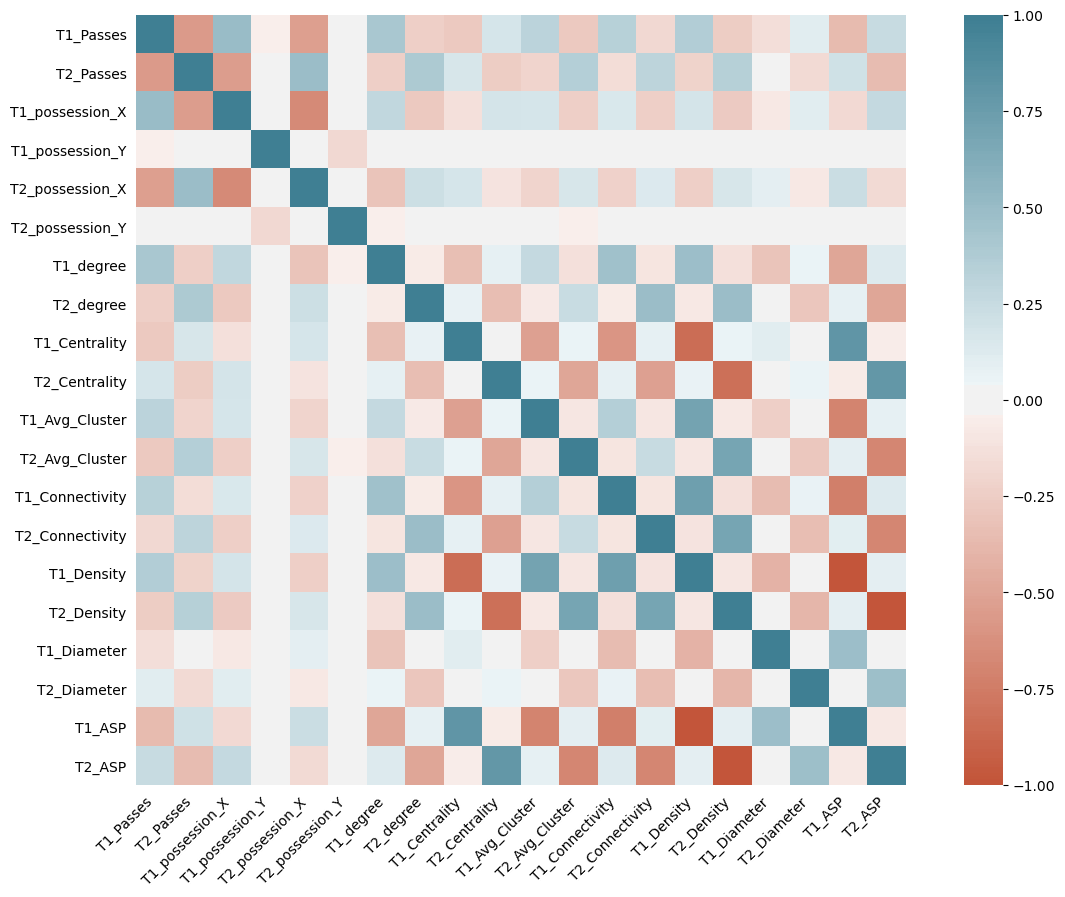

In [40]:
#Plot correlation matrix into heatmap

plt.subplots(figsize=(15,10))
ax = sns.heatmap(
    corr_matrix, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    
)

ax.set_xticklabels(
    
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
    
);

ax.tick_params(left=False, bottom=False)


In [41]:
feature_df.Winner.value_counts()

Team_2    737
Team_1    730
Draw      474
Name: Winner, dtype: int64

In [42]:
x=feature_df
y=feature_df.Winner

In [43]:
del x['Winner']
del x['Team_1']
del x['Team_2']

In [44]:
# Check for imbalance in the dataset

imby = y.value_counts().sort_values()
imbx = ['Draw','Team_1','Team_2']

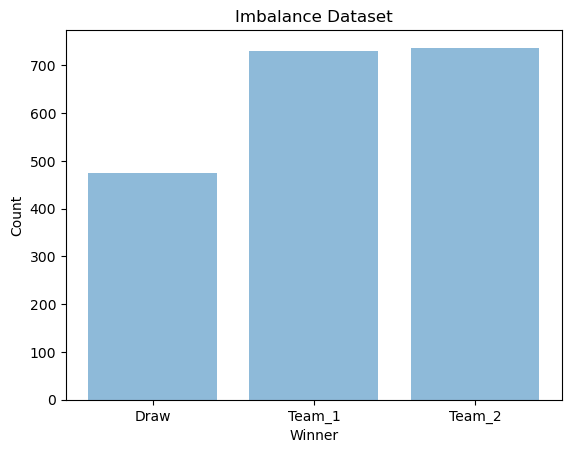

In [45]:
import matplotlib.pyplot as plt; plt.rcdefaults()

plt.bar(imbx, imby, align='center', alpha=0.5)
plt.xlabel('Winner')
plt.ylabel('Count')
plt.title('Imbalance Dataset')

plt.show()

In [46]:
# Split of dataset in test and train

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2 , random_state = 0)

In [47]:
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics

# Function to fit the model, perform CV and testing
def perform_cv_and_testing(classifier,x_train,y_train,x_test,y_test):
    classifier.fit(x_train, y_train)
    auc = cross_val_score(estimator = classifier, X = x_train, y = y_train, cv = 10,scoring='accuracy')
   
    print('------------------------------------------------------')
    print('\nk-fold CV Mean Accuracy {}\n'.format(auc.mean()))
    print('------------------------------------------------------\n')
    
    y_pred = classifier.predict(x_test)
    
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_test), columns=np.unique(y_test))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=(7,5))
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

    

    
    
    print('------------------------------------------------------\n')
    print('Classificaion Report\n\n')
    print(classification_report(y_test, y_pred, target_names=['Draw','Team_1','Team_2']))
   
    

   

------------------------------------------------------

k-fold CV Mean Accuracy 0.48517369727047155

------------------------------------------------------

------------------------------------------------------

Classificaion Report


              precision    recall  f1-score   support

        Draw       0.37      0.25      0.30        89
      Team_1       0.61      0.61      0.61       155
      Team_2       0.56      0.67      0.61       145

    accuracy                           0.55       389
   macro avg       0.51      0.51      0.51       389
weighted avg       0.54      0.55      0.54       389



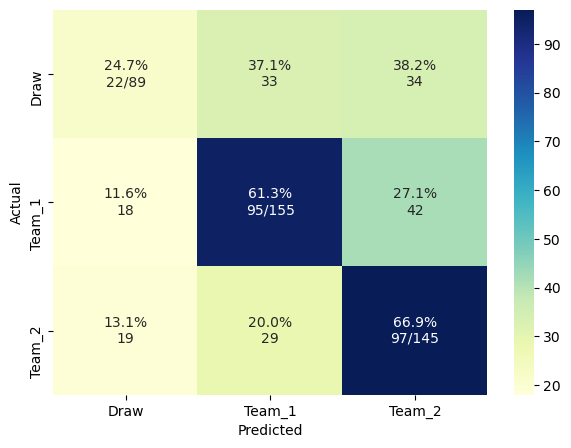

In [48]:
from xgboost import XGBClassifier

classifierX = XGBClassifier(max_depth = 6,learning_rate= 0.2, objective ='multi:softmax')
perform_cv_and_testing(classifierX,x_train,y_train,x_test,y_test)

In [50]:
y_pred = classifierX.predict(x_test)


In [51]:
# Wrong Prediction
y_test[y_pred != y_test]

Teams
Wolfsburg-K\u00f6ln                 Team_1
AFC Bournemouth-Everton             Team_2
Chelsea-West Ham United               Draw
Legan\u00e9s-Getafe                   Draw
SPAL-Milan                          Team_2
                                     ...  
Amiens SC-Monaco                      Draw
Spain-Czech Republic                Team_1
Napoli-Internazionale                 Draw
Villarreal-Real Sociedad            Team_1
Real Madrid-Atl\u00e9tico Madrid      Draw
Name: Winner, Length: 175, dtype: object

In [52]:
#Right Prediction
y_test[y_pred == y_test]

Teams
Tottenham Hotspur-Everton         Team_1
Chievo-Crotone                    Team_2
Nice-Guingamp                     Team_1
Hannover 96-Werder Bremen         Team_1
Germany-Ukraine                   Team_1
                                   ...  
Atalanta-Internazionale           Team_2
Schalke 04-Bayern M\u00fcnchen    Team_2
Caen-Angers                       Team_2
Espanyol-Getafe                   Team_1
Atl\u00e9tico Madrid-Eibar        Team_1
Name: Winner, Length: 214, dtype: object